# Desafío 3: generación de secuencias por caracter

## Obtención y análisis del dataset

In [2]:
# Se importan librerías esenciales.

import os
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, TimeDistributed, CategoryEncoding, SimpleRNN, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [4]:
# Si el dataset no se encuentra disponible, se scrappea desde la web y se almacena en el repositorio.

if os.access('./animal_farm.txt', os.F_OK) is False:

    urls = [
        'https://web.archive.org/web/20240407014849/http://www.george-orwell.org/Animal_Farm/0.html',
        'https://web.archive.org/web/20240407014848/http://www.george-orwell.org/Animal_Farm/1.html',
        'https://web.archive.org/web/20240407014848/http://www.george-orwell.org/Animal_Farm/2.html',
        'https://web.archive.org/web/20240407014848/http://www.george-orwell.org/Animal_Farm/3.html',
        'https://web.archive.org/web/20240407014848/http://www.george-orwell.org/Animal_Farm/4.html',
        'https://web.archive.org/web/20240407014848/http://www.george-orwell.org/Animal_Farm/5.html',
        'https://web.archive.org/web/20240407014848/http://www.george-orwell.org/Animal_Farm/6.html',
        'https://web.archive.org/web/20240407014848/http://www.george-orwell.org/Animal_Farm/7.html',
        'https://web.archive.org/web/20240407014848/http://www.george-orwell.org/Animal_Farm/8.html',
        'https://web.archive.org/web/20240407014848/http://www.george-orwell.org/Animal_Farm/9.html'
        ]

    book = ''

    for url in urls:
        chapter = scrap_text(url)
        book += chapter

    book_path = "./animal_farm.txt"

    with open(book_path, 'w', encoding='utf-8') as file:
        file.write(book)
else:
    pass

In [6]:
# Se lee el documento como str.

with open('./animal_farm.txt', 'r', encoding='utf-8') as book:
    dataset = book.read()

dataset[:1000]

' \n\n\n\n\n\n\n\n                                          \n                                          Animal Farm\n                                   \t\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nChapter I\n \n\n\n\n\n\n\nMr. Jones, of the Manor Farm, had locked the hen-houses for the night, but\n\nwas too drunk to remember to shut the pop-holes. With the ring of light\n\nfrom his lantern dancing from side to side, he lurched across the yard,\n\nkicked off his boots at the back door, drew himself a last glass of beer\n\nfrom the barrel in the scullery, and made his way up to bed, where\n\nMrs. Jones was already snoring.\n\n\n\nAs soon as the light in the bedroom went out there was a stirring and a\n\nfluttering all through the farm buildings. Word had gone round during the\n\nday that old Major, the prize Middle White boar, had had a strange dream\n\non the previous night and wished to communicate it to the other animals.\n\nIt had been agreed that they should all meet in the big barn 

## Preprocesamiento

In [7]:
# Se importan herramientas de preprocesamiento.

from tensorflow.keras.utils import pad_sequences # Se utilizará para padding.

In [8]:
# Se establece el tamaño máximo del contexto.

max_context_size = 100

In [9]:
# Se obtiene el conjunto de elementos únicos.

chars_vocab = set(dataset)

In [10]:
vocab_size = len(chars_vocab)

print('Tamaño del vocabulario:', vocab_size)

Tamaño del vocabulario: 75


In [11]:
# Se construyen los dicionarios que asignan índices a caracteres y viceversa.

char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

In [12]:
# Se tokeniza el texto completo.

tokenized_text = [char2idx[ch] for ch in dataset]

In [13]:
# Se visualiza un segmento del texto tokenizado.

tokenized_text[400:410]

[71, 42, 42, 17, 67, 54, 17, 7, 57, 4]

In [14]:
# Se separa el dataset entre entrenamiento y validación.

p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [15]:
# Se separa la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [16]:
# Se tokeniza la porción de texto para entrenamiento.

tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [17]:
# Se tokeniza la porción de texto para validación.

tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [18]:
# Se establecen entradas y targets.

X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

In [19]:
X.shape

(155772, 100)

In [20]:
X[500,50:60]

array([51, 29, 52,  7, 37,  4, 69, 21, 37,  4])

In [21]:
y[500,50:60]

array([29, 52,  7, 37,  4, 69, 21, 37,  4, 21])

## Entrenamiento de modelos

In [22]:
# Se crea una función para registrar la perplejidad durante el entrenamiento
# y establecer un criterio de detención.

class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=5):
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      for seq in self.val_data:

        len_seq = len(seq)
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        for start,end in self.info:

          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model_char.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True

### Modelo original

In [20]:
model = Sequential()

model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 time_distributed (TimeDist  (None, None, 75)          0         

 ributed)                                                        

                                                                 

 simple_rnn (SimpleRNN)      (None, None, 200)         55200     

                                                                 

 dense (Dense)               (None, None, 75)          15075     

                                                                 


Total params: 70275 (274.51 KB)

Trainable params: 70275 (274.51 KB)

Non-trainable params: 0 (0.00 Byte)

_________________________________________________________________


In [21]:
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=256)

Epoch 1/20

609/609 [==============================] - ETA: 0s - loss: 2.3812

 mean perplexity: 8.1263736470535 



Saved new model!

609/609 [==============================] - 70s 109ms/step - loss: 2.3812

Epoch 2/20

609/609 [==============================] - ETA: 0s - loss: 1.9968

 mean perplexity: 6.698115159247989 



Saved new model!

609/609 [==============================] - 67s 110ms/step - loss: 1.9968

Epoch 3/20

609/609 [==============================] - ETA: 0s - loss: 1.8543

 mean perplexity: 5.9532080093981765 



Saved new model!

609/609 [==============================] - 65s 107ms/step - loss: 1.8543

Epoch 4/20

609/609 [==============================] - ETA: 0s - loss: 1.7750

 mean perplexity: 5.775073091471391 



Saved new model!

609/609 [==============================] - 70s 114ms/step - loss: 1.7750

Epoch 5/20

609/609 [==============================] - ETA: 0s - loss: 1.7253

 mean perplexity: 5.753089806238115 



Saved new model!

609/609 [===========

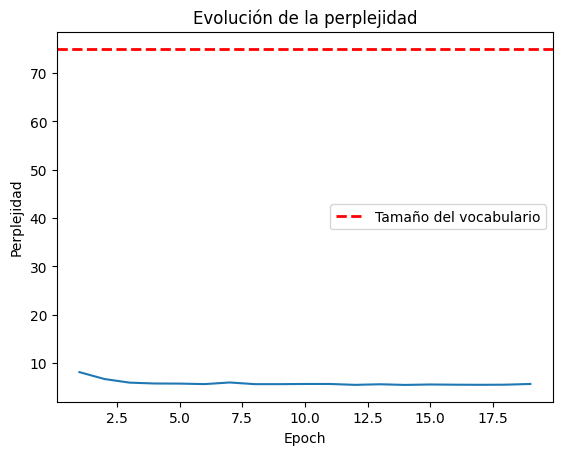

In [22]:
# Se grafica la evolución de la perplejidad con las épocas.

import matplotlib.pyplot as plt
import seaborn as sns

epoch_count = range(1, len(history_ppl) + 1)

ax = sns.lineplot(x=epoch_count,  y=history_ppl)
ax.axhline(y=vocab_size, color='r', linestyle='--', linewidth=2, label='Tamaño del vocabulario')

ax.set_title('Evolución de la perplejidad')
ax.set_ylabel('Perplejidad')
ax.set_xlabel('Epoch')
ax.legend()

plt.show()

### Modelo alternativo propuesto

Luego de haber explorado capas `GRU` de distinta complejidad (n capas, n neuronas, bidireccionales y con diferentes valores de dropout), se observó que este problema es mejor manejado por celdas de Elman. Además se ha probado con distintos valores máximos de contexto, sin evidenciar cambios significativos.

Se propone finalmente un modelo similar al original, con dos capas identicas adicionales y capas `BatchNormalization` para mayor estabilidad del entrenamiento.

In [36]:
alt_model = Sequential()

alt_model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))

alt_model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
alt_model.add(BatchNormalization())

alt_model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
alt_model.add(BatchNormalization())

alt_model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
alt_model.add(BatchNormalization())

alt_model.add(Dense(vocab_size, activation='softmax'))

alt_model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

alt_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_3              │ (None, None, 75)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, None, 200)      │        55,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, None, 200)      │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, None, 200)      │        80,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, None, 200)      │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, None, 200)      │        80,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, None, 200)      │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, None, 75)       │        15,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 233,075 (910.45 KB)

 Trainable params: 231,875 (905.76 KB)

 Non-trainable params: 1,200 (4.69 KB)

In [37]:
history_ppl = []
hist = alt_model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val, history_ppl)], batch_size=256)

Epoch 1/20
  2/609 ━━━━━━━━━━━━━━━━━━━━ 51s 85ms/step - loss: 4.9536   

W0000 00:00:1721519893.926610     145 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 2.4058

W0000 00:00:1721519935.092877     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



 mean perplexity: 5.330723559346401 

Saved new model!
609/609 ━━━━━━━━━━━━━━━━━━━━ 65s 80ms/step - loss: 2.4051
Epoch 2/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.6263
 mean perplexity: 5.232660652010122 

Saved new model!
609/609 ━━━━━━━━━━━━━━━━━━━━ 32s 52ms/step - loss: 1.6263
Epoch 3/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.5553
 mean perplexity: 5.5517567701351975 

609/609 ━━━━━━━━━━━━━━━━━━━━ 32s 52ms/step - loss: 1.5553
Epoch 4/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.5204
 mean perplexity: 5.418614035621425 

609/609 ━━━━━━━━━━━━━━━━━━━━ 32s 52ms/step - loss: 1.5203
Epoch 5/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.5015
 mean perplexity: 5.084293547188735 

Saved new model!
609/609 ━━━━━━━━━━━━━━━━━━━━ 32s 52ms/step - loss: 1.5015
Epoch 6/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.4862
 mean perplexity: 5.08271765883288 

Saved new model!
609/609 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - loss: 1.4862
Epoch 7/20
608/

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


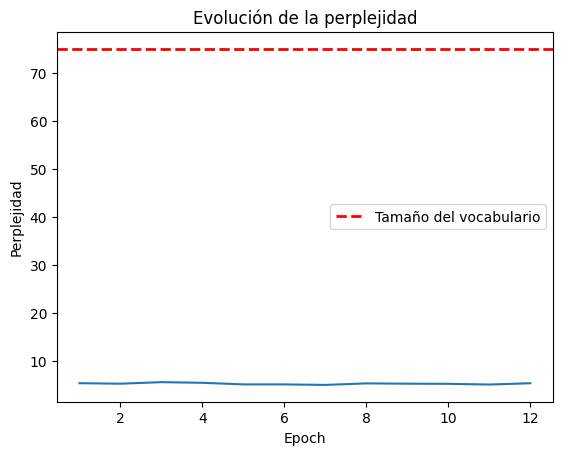

In [38]:
# Se grafica la evolución de la perplejidad con las épocas.

import matplotlib.pyplot as plt
import seaborn as sns

epoch_count = range(1, len(history_ppl) + 1)

ax = sns.lineplot(x=epoch_count, y=history_ppl)
ax.axhline(y=vocab_size, color='r', linestyle='--', linewidth=2, label='Tamaño del vocabulario')

ax.set_title('Evolución de la perplejidad')
ax.set_ylabel('Perplejidad')
ax.set_xlabel('Epoch')
ax.legend()

plt.show()

Si bien se observa que el modelo mejora, la diferencia es muy leve. Resulta entonces probable que con los datos suministrados se esté cerca del óptimo global.

## Evaluación del modelo

In [23]:
# Se carga el mejor modelo.
model = keras.models.load_model('my_model_char.keras')

### Predicción del siguiente caracter

In [25]:
# Se utiliza la librería Gradio para generar predicciones del prócimo caracter.

import gradio as gr

def model_response(human_text):

    encoded = [char2idx[ch] for ch in human_text.lower() ]
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    y_hat = np.argmax(model.predict(encoded)[0,-1,:])

    out_word = ''
    out_word = idx2char[y_hat]

    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


I0000 00:00:1721521340.876544   19456 service.cc:145] XLA service 0x7f435000b040 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721521340.876574   19456 service.cc:153]   StreamExecutor device (0): Host, Default Version
2024-07-20 21:22:21.132800: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


I0000 00:00:1721521341.770439   19456 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Keyboard interruption in main thread... closing server.


No se observa un buen desempeño del modelo.

### Predicción de los siguientes _n_ caracteres

In [26]:
# En este caso se predicen los próximos n caracteres.

def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text

    for _ in range(n_words):
        encoded = [char2idx[ch] for ch in output_text.lower() ]
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
        out_word = ''

        out_word = idx2char[y_hat]

        output_text += out_word

    return output_text

In [28]:
input_text='the animal far'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'the animal far!dPt!wFt!,pB!dPwH!;xB,SdPt!H!X'

Nuevamente, no se observa un buen desempeño del modelo.

###  Beam search

In [31]:
# Se definen funciones para codificar y decodificar textos.

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [32]:
# Se crean funciones para realizar beam search determinístico y estocástico.

from scipy.special import softmax

def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams]
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    encoded = encode(input)

    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    vocab_size = y_hat.shape[0]

    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        input_update = np.array([hist[i+1:]]).copy()

        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

Se infiere con **beam search determinístico.**

In [33]:
beam_det_output = beam_search(
    model,
    num_beams=10,
    num_words=15,
    input="The animal far",
    mode='det')

In [48]:
decode(beam_det_output[1])

'UUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUThe animal fart!j,?wYtwp!H,L!'

Si bien la secuencia obtenida lejos se encuentra de ser ideal, al menos se obtuvo un segmento de frase gracioso.

Se infiere con **beam search estocástico y baja temperatura.**

In [49]:
beam_sto_low_t = beam_search(
    model,
    num_beams=10,
    num_words=15,
    input="The animal far",
    temp=0.5,
    mode='sto')

In [58]:
decode(beam_sto_low_t[0])

'UUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUThe animal far!dPt!,pNJ,YL!Ht'

In [59]:
decode(beam_sto_low_t[5])

'UUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUThe animal far!dPt!,pNJ,YL!Ht'

In [60]:
decode(beam_sto_low_t[9])

'UUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUThe animal far!dPt!,pNJ,YL!Ht'

Se observa que los 10 beams creados son idénticos.

Se infiere con **beam search estocástico y alta temperatura.**

In [68]:
beam_sto_high_t = beam_search(
    model,
    num_beams=10,
    num_words=15,
    input="The animal farm",
    temp=2,
    mode='sto')

In [75]:
decode(beam_sto_high_t[5])

'UUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUThe animal farm!5wutS!,pB  PNJ'

Se sigue sin obtener resultados aceptables.

## Conclusión final

Se concluye que es mucho más sencillo entrenar modelos de lenguaje utilizando palabras como términos y oraciones como documentos. 